Getting started
============

This is a quick overview of multiple capabilities of ``pvfactors``:

- create a PV array
- use the engine to update the PV array
- plot the PV array 2D geometry for a given timestamp index
- run a timeseries bifacial simulation using the "fast mode"
- run a timeseries bifacial simulation using the "full mode"

Imports and settings

In [1]:
# Import external libraries
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

# Settings
%matplotlib inline
np.set_printoptions(precision=3, linewidth=300)

### Get timeseries inputs

In [2]:
df_inputs = pd.DataFrame(
    {'solar_zenith': [20., 50.],
     'solar_azimuth': [110., 250.],
     'surface_tilt': [10., 20.],
     'surface_azimuth': [90., 270.],
     'dni': [1000., 900.],
     'dhi': [50., 100.],
     'albedo': [0.2, 0.2]}, 
    index=[datetime(2017, 8, 31, 11), datetime(2017, 8, 31, 15)]
)
df_inputs

,solar_zenith,solar_azimuth,surface_tilt,surface_azimuth,dni,dhi,albedo
2017-08-31 11:00:00,20.0,110.0,10.0,90.0,1000.0,50.0,0.2
2017-08-31 15:00:00,50.0,250.0,20.0,270.0,900.0,100.0,0.2


### Prepare some PV array parameters

In [3]:
pvarray_parameters = {
    'n_pvrows': 3,            # number of pv rows
    'pvrow_height': 1,        # height of pvrows (measured at center / torque tube)
    'pvrow_width': 1,         # width of pvrows
    'axis_azimuth': 0.,       # azimuth angle of rotation axis
    'gcr': 0.4,               # ground coverage ratio
}

### Create a PV array and update it with the engine

Use the ``PVEngine`` and the ``OrderedPVArray`` to run simulations

In [4]:
from pvfactors.engine import PVEngine
from pvfactors.geometry import OrderedPVArray

# Create an ordered PV array
pvarray = OrderedPVArray.init_from_dict(pvarray_parameters)
# Create engine using the PV array
engine = PVEngine(pvarray)
# Fit engine to data: which will update the pvarray object as well
engine.fit(df_inputs.index, df_inputs.dni, df_inputs.dhi, 
           df_inputs.solar_zenith, df_inputs.solar_azimuth, 
           df_inputs.surface_tilt, df_inputs.surface_azimuth, 
           df_inputs.albedo)

The user can then plot the PV array 2D geometry for any of the simulation timestamp

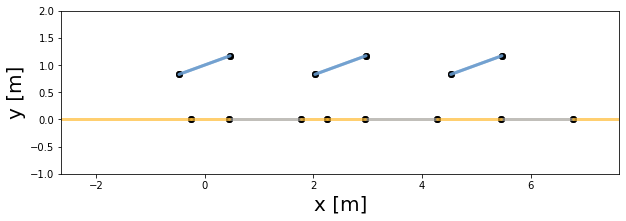

In [5]:
# Plot pvarray shapely geometries
f, ax = plt.subplots(figsize=(10, 3))
pvarray.plot_at_idx(1, ax)
plt.show()

### Run simulation using the fast mode

The "fast mode" allows the user to get almost instantaneous calculation results for the incident irradiance on the back surface of the PV rows. It assumes that the incident irradiance values on surfaces other than back surfaces are known (e.g. from the Perez transposition model).

In [6]:
# Create a function that will build a report from the simulation and return the 
# incident irradiance on the back surface of the middle PV row
def fn_report(pvarray): return pd.DataFrame({'qinc_back': pvarray.ts_pvrows[1].back.get_param_weighted('qinc')})

# Run the fast mode calculation on the middle PV row
df_report_fast = engine.run_fast_mode(fn_build_report=fn_report, pvrow_index=1)

# Print the results
print('Incident irradiance on back surface of middle PV row: \n')
df_report_fast

Incident irradiance on back surface of middle PV row: 



,qinc_back
2017-08-31 11:00:00,110.586509
2017-08-31 15:00:00,86.943571


### Run simulation using the full mode

The "full mode" allows the user to run the irradiance calculations by accounting for the equilibrium of reflections between all the surfaces in the system. So it is more precise than the "fast mode", but it takes a little longer to run.

In [7]:
# Create a function that will build a report: here we use an example that reports irradiance on center PV row
from pvfactors.report import example_fn_build_report

# Run full mode simulation
report = engine.run_full_mode(fn_build_report=example_fn_build_report)

100%|██████████| 2/2 [00:00<00:00, 37.55it/s]


In [8]:
# Print results (report is defined by report function passed by user)
df_report_full = pd.DataFrame(report, index=df_inputs.index)

print('Incident irradiance on back surface of middle PV row: \n')
df_report_full[['qinc_back']]

Incident irradiance on back surface of middle PV row: 



,qinc_back
2017-08-31 11:00:00,106.627832
2017-08-31 15:00:00,79.668878


We can observe here some differences between the fast and full modes for the back surface total irradiance, which are mainly due the difference in how reflections are accounted for.